# Set Up

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\xiayu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# !python -m pip install tensorflow

In [3]:
#!pip install tensorflow-gpu==2.12.0

In [4]:
#!pip install protobuf==3.20.0

In [5]:
#print("TensorFlow Version:", tf.__version__)


In [6]:
# import tensorflow as tf

# print("TensorFlow-GPU version:", tf.__version__)


In [7]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [8]:
plt.imshow??

In [9]:
#functional api import 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Folder Structures

In [10]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:
os.makedirs(POS_PATH, exist_ok = True)
os.makedirs(NEG_PATH, exist_ok = True)
os.makedirs(ANC_PATH, exist_ok = True)

# Collect positive and anchors

In [12]:
#Uncompress the GZ file
# !tar -xf lfw.tgz

# Move the Images to data/negative

In [13]:
# for directory in os.listdir('lfw'):
#     directory_path = os.path.join('lfw', directory)
#     for file in os.listdir(directory_path):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

# Collect Positive and Anchor Classes

In [14]:
#get unique id
import uuid

In [15]:
uuid.uuid1()

UUID('3bbaf984-3213-11ee-b153-c4bde5784b6d')

In [16]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #resize frame
    frame = frame[100:120+250, 200:200+250, :]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write img
        cv2.imwrite(imgname, frame)
        
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
         #write img
         cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection", frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#release webcam and close image show frame
cap.release()
cv2.destroyAllWindows()

In [17]:
frame.shape

(270, 250, 3)

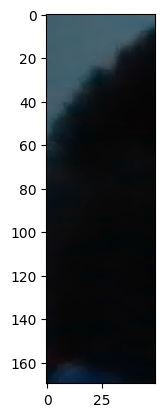

In [18]:
plt.imshow(frame[100:120+250, 200:200+250, :])

# Get Image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
dir_test.next()

b'data\\anchor\\0007fa7c-3009-11ee-ab5c-c4bde5784b6d.jpg'

# Preprocessing

In [22]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #Preprocessing resizing the image to be 100X100X3
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1
    img = img /255.0
    return img

In [23]:
img = preprocess('data\\anchor\\ffee009d-3008-11ee-9149-c4bde5784b6d.jpg')

In [24]:
img.numpy().max()

0.8734313

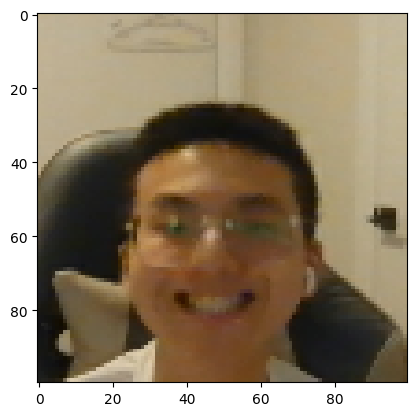

In [25]:
plt.imshow(img)

# Create Labelled Dataset

In [26]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [27]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [29]:
example = data.as_numpy_iterator()

In [30]:
sample = example.next()

# Build Train and Test Partition

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
res = preprocess_twin(*sample)

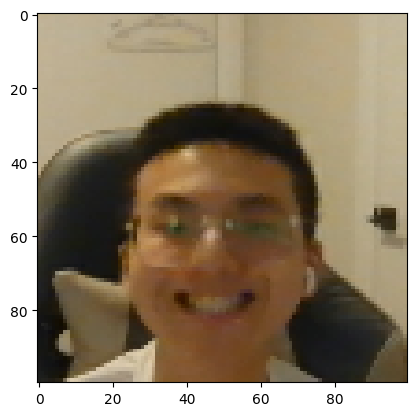

In [33]:
plt.imshow(res[0])

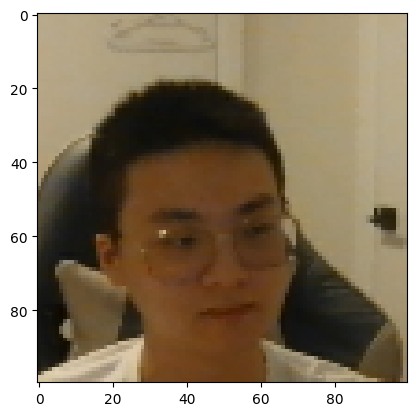

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
#Build dataLoader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
samples = data.as_numpy_iterator()

In [38]:
sam = samples.next()

In [39]:
len(sam)

3

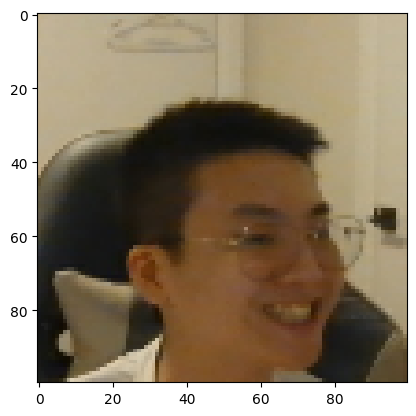

In [40]:
plt.imshow(sam[0])

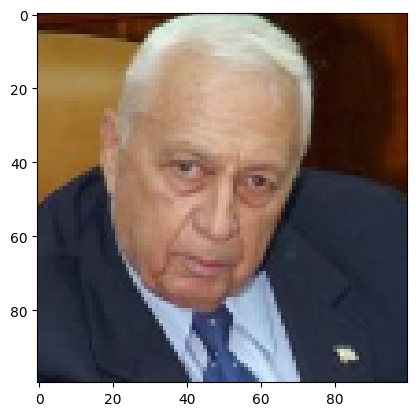

In [41]:
plt.imshow(sam[1])

In [42]:
sam[2]

0.0

In [43]:
#Training Partition
train_data = data.take(round(len(data)* .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [44]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [45]:
samples = train_data.as_numpy_iterator()

In [46]:
sample = samples.next()

In [47]:
sample[0]

array([[[[0.7662745 , 0.707451  , 0.59372544],
         [0.7658334 , 0.70700985, 0.5932843 ],
         [0.76960784, 0.7137255 , 0.6       ],
         ...,
         [0.7760294 , 0.725049  , 0.59955883],
         [0.78333336, 0.7264706 , 0.6039216 ],
         [0.7849019 , 0.7260784 , 0.59666663]],

        [[0.7658824 , 0.70705885, 0.58117646],
         [0.77254903, 0.7137255 , 0.5878431 ],
         [0.76862746, 0.70980394, 0.58392155],
         ...,
         [0.77906865, 0.7259314 , 0.6069118 ],
         [0.78200984, 0.72887254, 0.6098529 ],
         [0.78431374, 0.72764707, 0.61039215]],

        [[0.77254903, 0.7137255 , 0.58431375],
         [0.77254903, 0.7137255 , 0.58431375],
         [0.7732843 , 0.7144608 , 0.58504903],
         ...,
         [0.76862746, 0.7254902 , 0.6156863 ],
         [0.764951  , 0.72181374, 0.6120098 ],
         [0.78039217, 0.7254902 , 0.61960787]],

        ...,

        [[0.5509804 , 0.53995097, 0.49093136],
         [0.55465686, 0.54362744, 0.4897059 ]

In [48]:
# test partition
test_data = data.skip(round(len(data)* .7))
test_data = test_data.take(round(len(data)* .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## 1. build embedding layer
### Create a function

In [49]:
inp = Input(shape=(105,105,3), name = 'input_image')

In [50]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [51]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [52]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [53]:
m1 = MaxPooling2D(64, (2,2), padding = "same")(c1)

In [54]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [55]:
c2 = Conv2D(128,(7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding = "same")(c2)
c3 = Conv2D(128,(4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding = "same")(c3)

In [56]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [57]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation = 'sigmoid')(f1)

In [58]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

# By using function below the Model has build

In [60]:
import tensorflow as tf
import torch
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
#     device = torch.device('cpu')

def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    
    #first block
#     with tf.device('/GPU:0'):
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = "same")(c1)
    
    #second
#     with tf.device('/GPU:0'):
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = "same")(c2)
    
    #third
#     with tf.device('/GPU:0'):
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = "same")(c3)
    
    #final embedding block
#     with tf.device('/GPU:0'):
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [61]:
embedding = make_embedding()

In [62]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 2. Build Distance Layer

In [63]:
#Siamese L1 Distance Class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    #important
    #Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [64]:
l1 = L1Dist()

In [65]:
input_image = Input(name='input_img', shape = (100,100,3))
    
#validation Img in the network
validation_image = Input(name = 'validation_img', shape = (100,100,3))

In [66]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

### put the input and validation img into embedding function that we declared before, the img will be modified

In [67]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [68]:
siamese_layer = L1Dist()

In [69]:
distances = siamese_layer(inp_embedding, val_embedding)

In [70]:
classifier = Dense(1, activation='sigmoid')(distances)

In [71]:
classifier  #Shape 1

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [72]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [73]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### 1. input image validation image
### 2. goes to embedding(function)  layer
### 3. combined through L1Dist() layer
### 4. output a single value (shape 1)

### 4096 = distance between inp_embedding and val_embedding

## 3. Make Siamese Model

In [74]:
def make_siamese_model():
    #Handle Anchor Inputs in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))
    
    #validation Img in the network
    validation_iamge = Input(name = 'validation_img', shape = (100,100,3))
    
    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

In [75]:
siamese_model = make_siamese_model()

In [76]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Start To Training

## 1. Set up Loss and Optimizer

In [77]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [78]:
#Find keras Adam optimizer
opt = tf.keras.optimizers.Adam(1e-4)

## 2. Establish Checkpoints

In [79]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

## 3. Build Train Step Function

In [80]:
test_batch = train_data.as_numpy_iterator()

In [81]:
batch_1 = test_batch.next()

In [82]:
len(batch_1)

3

In [83]:
len(batch_1[1]) #16 images in index

16

In [84]:
batch_1[2] #all labels

array([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [85]:
X = batch_1[:2]

In [86]:
np.array(X).shape #2 components 16 imgs each , 100 by 100 by 3

(2, 16, 100, 100, 3)

In [87]:
y = batch_1[2]

In [88]:
tf.losses.BinaryCrossentropy??

In [89]:


@tf.function #compiles a function into a callable TensorFlow graph
def train_step(batch):
    with tf.device('/GPU:0'):
        with tf.GradientTape() as tape: #Record operation for automatic differention

            #Get anchor and positive/negative image
            X = batch[:2]
            #Get Label
            y = batch[2]

            #Forward pass
            yhat = siamese_model(X, training = True)

            #calculate loss  bce(y_true, y_pred).numpy() 
            loss = binary_cross_loss(y,yhat)
        print(loss)

        #calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)

        #calculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

        #return loss
        return loss

## 4. Build Training Loop

In [91]:
def train(data, EPOCHS):
    #Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        #Loop through each batch
        for idx, batch in enumerate(data):
            
            #run the train step:
            train_step(batch)
            progbar.update(idx+1)
        if epoch %10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

## 5. Train the Model

In [92]:
EPOCHS = 1

In [93]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')

# # 设置GPU可见性
# tf.config.experimental.set_visible_devices(gpus, 'GPU')

# for gpu in gpus:
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)

In [94]:
# import torch
# print("Num GPUs Available: ", torch.cuda.device_count())

In [95]:
# torch.cuda.is_available()

In [96]:
train(train_data, EPOCHS)


 Epoch1/1
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32, device=/device:GPU:0)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32, device=/device:GPU:0)
27/27 [==============================] - 416s 15s/step


# Evaluate Model

## 1. import metric

In [97]:
# Import metric calculatrions
from tensorflow.keras.metrics import Precision, Recall

## 2. Make Predictions

In [119]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [120]:
test_var = test_data.as_numpy_iterator().next()

In [121]:
len(test_var)

3

In [122]:
len(test_var[0])

16

In [123]:
y_hat = predictions = siamese_model.predict([test_input, test_val])
y_hat

array([[4.2241514e-03],
       [9.6822691e-01],
       [7.2088361e-01],
       [4.1822770e-01],
       [1.8113554e-03],
       [6.7939520e-01],
       [5.8097452e-02],
       [6.1782765e-01],
       [5.0687343e-02],
       [9.0565884e-01],
       [5.0151348e-04],
       [1.0570288e-03],
       [1.0970953e-01],
       [8.5409343e-01],
       [7.7393270e-01],
       [3.7302464e-01]], dtype=float32)

In [124]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]

In [125]:
y_true

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

## 3. Calculate Metrics

In [126]:
#creating a metric object
m = Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#return Recall Result
m.result().numpy()

0.85714287

## 4. Viz Results

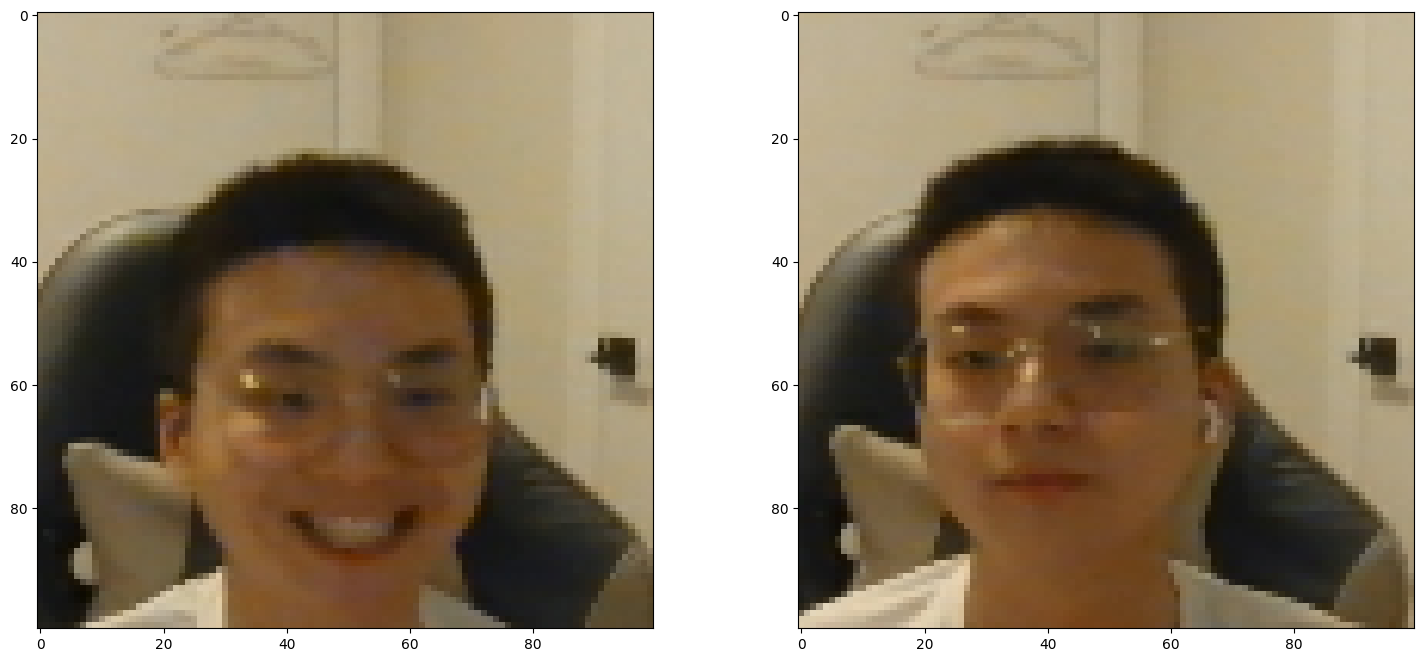

In [129]:
#set plot size
plt.figure(figsize = (18,8))

#set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()

# Save Model

In [130]:
# Save weights
siamese_model.save('SiameseModel.h5')

In [133]:
#Reload Model
model = tf.keras.models.load_model('SiameseModel.h5', custom_objects = {'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [134]:
tf.keras.models.load_model??

# Real Time Test